In [60]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


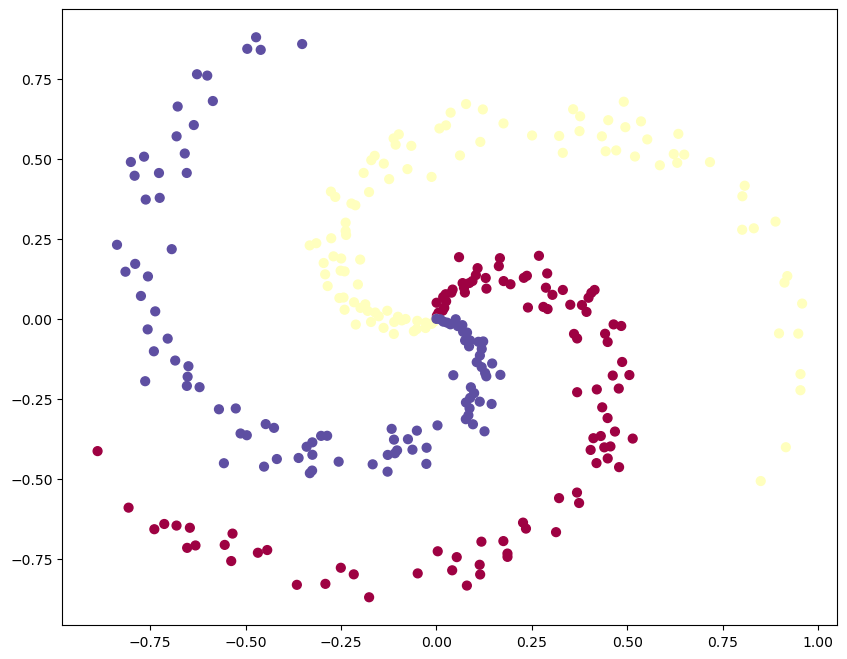

In [61]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [62]:
def sigmoid(x):
    x = 1/(1+np.exp(-x))
    return x

def sigmoid_grad(x):
    return (x)*(1-x)

def relu(x):
    return np.maximum(0,x)

In [63]:
# function to train 3 layer neural net and 2 hidden layer either relu or digmoid
def three_layer_net(NONLINEARITY, X, y, model, step_size):
    
    h = model['h']
    h2 = model['h2']
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
    
    
    # some hyperparameters
    reg = 0.5
    
    #gradient descent loop   
    num_examples = X.shape[0]
    plot_array_1 = []
    plot_array_2 = []
    
    for i in range(step_size):
        
        # forward prop
        if NONLINEARITY == 'RELU':
            hidden_layer = relu(np.dot(X, W1)+b1)
            hidden_layer2 = relu(np.dot(hidden_layer, W2)+b2)
            scores = np.dot(hidden_layer2, W3) + b3
            
        elif NONLINEARITY == 'SIGM':
            hidden_layer = sigmoid(np.dot(X, W1)+b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer, W2)+b2)
            scores = np.dot(hidden_layer2, W3) + b3
        
        # normalize / softmax
        epsilon = 1e-10
        exp_scores = np.exp(scores + epsilon)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        #compute the loss
        corect_logprobs = -np.log(probs[range(num_examples),y])
        data_loss = np.sum(corect_logprobs)/num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)+ 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        if i%1000 == 0:
            print(f"iteration {i}: loss {loss}")
        
        # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples), y] -= 1
        dscores /= num_examples
        
        # backprop here
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True)
        
        if NONLINEARITY == 'RELU':
            #backprop relu non...
            dhidden2 = np.dot(dscores, W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 = np.dot(hidden_layer.T, dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = np.dot(dhidden2, W2.T)
            dhidden[hidden_layer <= 0] = 0
         
        elif NONLINEARITY == 'SIGM':
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2))/np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2, axis=0)
            dhidden = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer)
            
        dW1 = np.dot(X.T, dhidden)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden, axis=0)
        
        #add regularization
        dW3 += reg*W3
        dW2 += reg *W2
        dW1 += reg*W1
        
        grads = {}
        grads['W1'] = dW1
        grads['W2'] = dW2
        grads['W3'] = dW3
        grads['b1'] = db1
        grads['b2'] = db2
        grads['b3'] = db3
        
        # return loss, grads
        W1 += -step_size*dW1
        b1 += -step_size*db1
        W2 += -step_size*dW2
        b2 += -step_size*db2
        W3 += -step_size*dW3
        b3 += -step_size*db3
        
    if NONLINEARITY == 'RELU':
        hidden_layer = relu(np.dot(X, W1) + b1)
        hidden_layer2 = relu(np.dot(hidden_layer, W2) + b2)

    elif NONLINEARITY == 'SIGM':
        hidden_layer = sigmoid(np.dot(X, W1) + b1)
        hidden_layer2 = sigmoid(np.dot(hidden_layer, W2) + b2)

    scores = np.dot(hidden_layer2, W3) + b3
    predicted_class = np.argmax(scores, axis=1)
    print(f"training accuracy: {np.mean(predicted_class==y):.2f}")

    return plot_array_1, plot_array_2, W1, W2, W3, b1, b2, b3
        

In [64]:
h=50
h2=50
num_train_examples = X.shape[0]

model = {}
model['h'] = h
model['h2'] = h2
model['W1'] = 0.1 * np.random.randn(D,h)
model['b1'] = np.zeros((1,h))
model['W2'] = 0.1 * np.random.randn(h,h2)
model['b2'] = np.zeros((1,h2))
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b3'] = np.zeros((1,K))

(sigm_array_1, sigm_array_2, s_W1, s_W2, s_W3, s_b1, s_b2, s_b3) = three_layer_net("SIGM", X, y, model, 50000)

iteration 0: loss 7.583863789928424
iteration 10: loss nan
iteration 20: loss nan
iteration 30: loss nan
iteration 40: loss nan
iteration 50: loss nan
iteration 60: loss nan
iteration 70: loss nan
iteration 80: loss nan
iteration 90: loss nan
iteration 100: loss nan
iteration 110: loss nan
iteration 120: loss nan


/tmp/ipykernel_2275502/2384573841.py:2: RuntimeWarning: overflow encountered in exp
  x = 1/(1+np.exp(-x))
/tmp/ipykernel_2275502/4140232103.py:37: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores + epsilon)
/tmp/ipykernel_2275502/4140232103.py:38: RuntimeWarning: invalid value encountered in divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
/tmp/ipykernel_2275502/4140232103.py:41: RuntimeWarning: divide by zero encountered in log
  corect_logprobs = -np.log(probs[range(num_examples),y])


iteration 130: loss nan
iteration 140: loss nan
iteration 150: loss nan
iteration 160: loss nan
iteration 170: loss nan
iteration 180: loss nan
iteration 190: loss nan
iteration 200: loss nan
iteration 210: loss nan
iteration 220: loss nan
iteration 230: loss nan
iteration 240: loss nan
iteration 250: loss nan
iteration 260: loss nan
iteration 270: loss nan
iteration 280: loss nan
iteration 290: loss nan
iteration 300: loss nan
iteration 310: loss nan
iteration 320: loss nan
iteration 330: loss nan
iteration 340: loss nan
iteration 350: loss nan
iteration 360: loss nan
iteration 370: loss nan
iteration 380: loss nan
iteration 390: loss nan
iteration 400: loss nan
iteration 410: loss nan
iteration 420: loss nan
iteration 430: loss nan
iteration 440: loss nan
iteration 450: loss nan
iteration 460: loss nan
iteration 470: loss nan
iteration 480: loss nan
iteration 490: loss nan
iteration 500: loss nan
iteration 510: loss nan
iteration 520: loss nan
iteration 530: loss nan
iteration 540: l

KeyboardInterrupt: 

In [ ]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('sum of magnitude of gradients -- SIGM weights')
plt.legend(("sigm first layer", "sigm second layer"))

NameError: name 'reg' is not defined